In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/kidongkim/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data formats
"ratings.dat" file format - UserID::MovieID::Rating::Timestamp
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings


"movies.dat" format - MovieID::Title::Genres
- Genres are pipe-separated and are selected from the following genres: [Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]
- Titles are identical to titles provided by the IMDB (including
year of release)
- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist


"users.dat" file format - UserID::Gender::Age::Occupation::Zip-code
- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges: {1:  "Under 18", 18:  "18-24", 25:  "25-34", 35:  "35-44", 45:  "45-49", 50:  "50-55", 56:  "56+"}

- Occupation is chosen from the following choices: {0:  "other" or "not specified", 1:  "academic/educator", 2:  "artist", 3:  "clerical/admin", 4:  "college/grad student", 5:  "customer service", 6:  "doctor/health care", 7:  "executive/managerial", 8:  "farmer", 9:  "homemaker", 10:  "K-12 student", 11:  "lawyer", 12:  "programmer", 13:  "retired", 14:  "sales/marketing", 15:  "scientist", 16:  "self-employed", 17:  "technician/engineer", 18:  "tradesman/craftsman", 19:  "unemployed", 20:  "writer"}

In [2]:
ratings = pd.read_csv('./cleaned_datasets/ratings.dat', 
                 delimiter='::', 
                 encoding='latin1', 
                 engine = 'python', 
                 header = None,
                 names = ['user_id', 'movie_id', 'rating', 'timestamp']
)
movies = pd.read_csv('./cleaned_datasets/movies.dat', 
                 delimiter='::', 
                 encoding = 'latin1',
                 header = None,
                 engine = 'python',
                 names = ['movie_id', 'title', 'genres']
)
users = pd.read_csv('./cleaned_datasets/users.dat', 
                 delimiter='::', 
                 encoding='latin1', 
                 engine = 'python', 
                 header = None,
                 names = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
)

In [3]:
from datetime import datetime

# TODO: later change to hive.sql
ratings['timestamp'] = ratings['timestamp'].apply(lambda timestamp: datetime.fromtimestamp(timestamp))

ratings = ratings.sort_values(['rating', 'timestamp'], ascending = [False, False])
ratings.head()

,user_id,movie_id,rating,timestamp
825438,4958,1407,5,2003-02-28 09:47:23
984025,5948,1180,5,2003-02-28 05:11:19
984632,5950,3196,5,2003-02-27 09:54:22
984849,5950,111,5,2003-02-27 09:50:41
984825,5950,2329,5,2003-02-27 09:45:48


In [4]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# Model Building (collaborative filtering; user-item matrix; KNN algorithm)
- input user_id & desired number of similar users, and will recommend movies rated by similar users  

In [6]:
# merge datasets
merged = pd.merge(ratings, users, how = 'inner', on = 'user_id')
merged = pd.merge(merged, movies, how = 'inner', on = 'movie_id')
merged.head()

ratings_cleaned = merged[['user_id', 'movie_id', 'rating']].sort_values(by=['user_id', 'movie_id', 'rating'])
print(ratings_cleaned.head())

print(f"Unique number of users in the dataset: {ratings_cleaned['user_id'].nunique()}")
print(f"Unique number of movies in the dataset: {ratings_cleaned['movie_id'].nunique()}")
    # why is number of movies smaller?? what happened?
    # are some movies not rated at all?

        user_id  movie_id  rating
171933        1         1       5
911414        1        48       5
21420         1       150       5
49104         1       260       4
34221         1       527       5
Unique number of users in the dataset: 6040
Unique number of movies in the dataset: 3706


#### Some movies in the movie dataset does not have any ratings.
These movies will not be used as input data.

In [7]:
# hence there are some movies missing in merged dataset
ratings[ratings['movie_id'] == 51]

,user_id,movie_id,rating,timestamp


In [8]:
missing_movies = movies[~movies['movie_id'].isin(ratings_cleaned['movie_id'].unique())]
missing_movies

,movie_id,title,genres
50,51,Guardian Angel (1994),Action|Drama|Thriller
107,109,Headless Body in Topless Bar (1995),Comedy
113,115,Happiness Is in the Field (1995),Comedy
141,143,Gospa (1995),Drama
281,284,New York Cop (1996),Action|Crime
...,...,...,...
3581,3650,Anguish (Angustia) (1986),Horror
3681,3750,Boricua's Bond (2000),Drama
3759,3829,Mad About Mambo (2000),Comedy|Romance
3786,3856,Autumn Heart (1999),Drama


### Train test split

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(ratings_cleaned, test_size=0.0001, random_state=42)

print(f"Unique number of users in the dataset: {train['user_id'].nunique()}")
print(f"Unique number of movies in the dataset: {train['movie_id'].nunique()}")

train

Unique number of users in the dataset: 6040
Unique number of movies in the dataset: 3706


,user_id,movie_id,rating
874228,4387,762,4
537386,3180,3040,3
562499,5433,292,2
460898,3592,305,3
507775,3144,1090,4
...,...,...,...
381337,1586,3507,5
927941,2129,2790,3
302949,854,1704,4
91883,4033,1199,5


### Create UIM matrix

In [10]:
test

,user_id,movie_id,rating
280460,5412,2431,5
430017,5440,111,5
642307,368,2976,3
201236,425,2139,4
566230,4942,2532,3
...,...,...,...
922674,3389,1792,2
275154,5795,750,5
896883,2445,1866,5
470583,5213,2028,4


In [11]:
# create user-item matrix 
user_to_movie = train.pivot(index = 'user_id', columns='movie_id', values='rating').fillna(0)

user_item_matrix = train.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
user_item_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalization by the average of individual user's rating

Idea : Normalize by extracting mean value per user based on the non-zero ratings of each user to non-zero ratings in the user-item matrix.

Modified matrix will have value ranging from -4 to 4 at theoratical maximum and minimum.
NaN values from the original user_item matrix has no preference on each movie. In our new scale of data, 0 is still the value represents no preference. As both non-viewed movies and the movies received exact mean scores of non-zero ratings of the user will have 0 score.

In [12]:
# Users' average rating on non-zero rating. We deal this rating as no preference. Neither good nor bad as well as non rated movies.
user_rating_avg = user_item_matrix.apply(lambda row: row[row != 0].mean(), axis=1)
user_rating_avg

user_id
1       4.188679
2       3.713178
3       3.901961
4       4.190476
5       3.146465
          ...   
6036    3.302928
6037    3.717822
6038    3.800000
6039    3.878049
6040    3.577713
Length: 6040, dtype: float64

In [13]:
# Function to apply subtraction based on a provided value list
def subtract_non_zero_by_row(row, sub_value):
    # Iterate through each element in the row and subtract the corresponding value only from non-zero elements
    return [val - sub_value if val != 0 else val for val in row]

# Apply the function row-by-row using the subtraction values list
modified_df = user_item_matrix.apply(lambda row: subtract_non_zero_by_row(row, user_rating_avg[row.name]), axis=1, result_type='expand')

print(modified_df.shape)

modified_df.iloc[:10, :10]

(6040, 3706)


,0,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,,
1,0.811321,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
5,0.000000,0.000000,0.0,0.000000,0.0,-1.146465,0.000000,0.0,0.0,0.0
6,0.098592,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
7,0.000000,0.000000,0.0,0.000000,0.0,-0.322581,0.000000,0.0,0.0,0.0
8,0.115108,0.000000,0.0,-0.884892,0.0,0.000000,0.000000,0.0,0.0,0.0
9,1.264151,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


<AxesSubplot:>

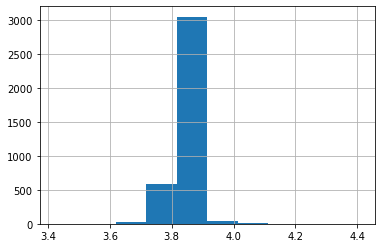

In [14]:
# train KNN model
from sklearn.neighbors import NearestNeighbors

knn_cf = NearestNeighbors(metric='cosine', algorithm='brute')
knn_cf.fit(modified_df)

# Returns average rating per each movie based on the nearest k nearest neighbors found based on the preference on movies. Default is 5.
def clf(user_id, k = 50):
    user_idx = users[users['user_id'] == user_id].index
    user_vect = modified_df.iloc[user_idx, :]

    distances_cf, idx_cf = knn_cf.kneighbors(
        user_vect,
        n_neighbors = k
    )

    predicted_nn = modified_df.iloc[idx_cf[0]].apply(lambda row: row + user_rating_avg[row.name] , axis=1)

    return predicted_nn.apply(np.mean, axis=0)

prediction = clf(1)
prediction.hist()

In [15]:
def get_top_k_movies_rated(user_id, num_recommendations = 5):
    return merged[merged['user_id'] == user_id].sort_values(
        ['rating', 'timestamp'], 
        ascending = False
    ).iloc[:num_recommendations]['title'].values


def get_top_k_movie_recommendations(user_id, k, num_recommendations = 5):
    # indices of top n movies.
    movie_indices = clf(user_id, k).sort_values(ascending = False).iloc[:num_recommendations].index
    return user_item_matrix.iloc[:, movie_indices].columns

def print_knn_result(user_id, num_recommendations = 5):
    print(f'Top {num_recommendations} movies rated by user {user_id}:')
    for movie_name in get_top_k_movies_rated(user_id):
        print(f'\t{movie_name}')        

    print(f'Recommended movies by similar users (collaborative filtering): ')
    for recs in get_top_k_movie_recommendations(user_id):
        print(f'\t{recs}')

print_knn_result(1)

Top 5 movies rated by user 1:
	Pocahontas (1995)
	Bug's Life, A (1998)
	Toy Story (1995)
	Beauty and the Beast (1991)
	Schindler's List (1993)
Recommended movies by similar users (collaborative filtering): 
	2028
	1
	527
	1193
	1961


### Model evaluation

In [21]:
"""
Takes in movies datagrame and merged ratings dataframe and returns a dataframe of movies with ratings only.
Returned dataframe only has 'movie_id', 'title' columns
"""
def movies_idx_df(movies, merged_ratings_df):
    # Exclude none rated movies and reset index.
    rated = movies[movies['movie_id'].isin(merged_ratings_df['movie_id'].unique())]
    return rated.reset_index(drop=True)[['movie_id', 'title']]

def get_movie_idx(movie_id):
    return movie_idx[movie_idx['movie_id'] == movie_id].index

movie_idx = movies_idx_df(movies, merged)

get_movie_idx(3948)

Int64Index([3701], dtype='int64')

In [40]:
def caldulate_rmse(df, actual_colname, pred_colname):
    return  np.sqrt(((df[actual_colname] - df[pred_colname]) ** 2).mean())

def make_knn_prediction(df, k = 10):
    df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)
    rmse = np.sqrt(((df['rating'] - df['prediction']) ** 2).mean())
    return df, rmse

prediction, rmse = make_knn_prediction(test, 20)
rmse

<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


1.050307435471635

In [36]:
_, train_testset = train_test_split(train, test_size=0.0001, random_state=42)
train_testset

,user_id,movie_id,rating
252246,964,356,4
19072,4240,1293,3
723036,5831,3712,3
815792,1794,58,3
904108,4449,3503,5
...,...,...,...
642086,4910,2826,4
373258,4649,2730,3
575467,3320,2144,4
337536,1015,932,4


In [37]:
test

,user_id,movie_id,rating,prediction
280460,5412,2431,5,3.384259
430017,5440,111,5,3.802955
642307,368,2976,3,3.277049
201236,425,2139,4,3.873182
566230,4942,2532,3,3.446427
...,...,...,...,...
922674,3389,1792,2,2.645483
275154,5795,750,5,3.927865
896883,2445,1866,5,3.184579
470583,5213,2028,4,3.955117


In [48]:
train_rmses = []
test_rmses = []
ks = list(range(50, 150, 5))

for k in ks:
    _, train_rmse = make_knn_prediction(train_testset, k)
    train_rmses.append(train_rmse)
    print(train_rmses)
    
    _, test_rmse = make_knn_prediction(test, k)
    test_rmses.append(test_rmse)
    print(test_rmses)


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073, 1.047424565545716]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756, 0.9085177196147712]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073, 1.047424565545716, 1.0454376706665467]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756, 0.9085177196147712, 0.9092817878527341]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073, 1.047424565545716, 1.0454376706665467, 1.045592430523967]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756, 0.9085177196147712, 0.9092817878527341, 0.9086965090581336]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073, 1.047424565545716, 1.0454376706665467, 1.045592430523967, 1.0445546066827907]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756, 0.9085177196147712, 0.9092817878527341, 0.9086965090581336, 0.9106165931819766]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073, 1.047424565545716, 1.0454376706665467, 1.045592430523967, 1.0445546066827907, 1.0449052638980527]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756, 0.9085177196147712, 0.9092817878527341, 0.9086965090581336, 0.9106165931819766, 0.9102185505095394]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[1.049520907112889, 1.0480139618616995, 1.0482237326706192, 1.0492979165506173, 1.051030477581273, 1.0474423641251813, 1.047571746536073, 1.047424565545716, 1.0454376706665467, 1.045592430523967, 1.0445546066827907, 1.0449052638980527, 1.04695017993497]


<ipython-input-40-880024b06851>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = df.apply(lambda row: float(clf(row['user_id'], k)[get_movie_idx(row['movie_id'])]), axis=1)


[0.8938061480606981, 0.8964952810787709, 0.8985881305319127, 0.9008720386147278, 0.900573620184072, 0.9019128890116292, 0.9049180372725236, 0.9058845476207756, 0.9085177196147712, 0.9092817878527341, 0.9086965090581336, 0.9106165931819766, 0.9102185505095394, 0.9113794062176768]


<AxesSubplot:>

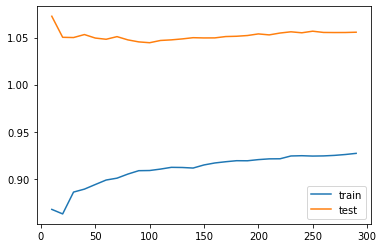

In [47]:
pd.DataFrame({"train": train_rmses, "test": test_rmses}, index = ks).plot()

<AxesSubplot:>

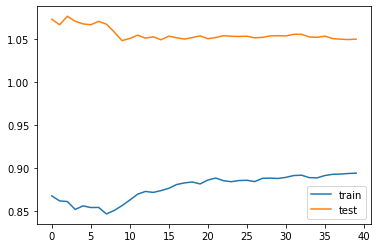

In [43]:
pd.DataFrame({"train": train_rmses, "test": test_rmses}, index = ks).plot()

### Hyperparameter tuning

# Scratchpad

In [86]:
import numpy as np
from pprint import pprint

def get_similar_users(user, n = 5):
    knn_input = np.asarray([user_to_movie.values[user-1]])
        # get user's row from user-item matrix
    distances, indices = knn.kneighbors(knn_input, n_neighbors = n+1)

    print(" ")
    print("Top", n, "users who are very much similar to the User ", user, "are: ")
    for i in range(1,len(distances[0])):
        print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
        
    return indices.flatten()[1:] + 1, distances.flatten()[1:]

def recommend_n_movies(user_id, n_similar_users, n_movie_recs):
    print(f'Movies seen by User {user_id}:')
    pprint(list(merged[merged['user_id'] == user_id]['title']))

    # get n_similar_users and their cosine similarity distances
    similar_users, distance_list = get_similar_users(user_id, n_similar_users)

    # define weights to ratings by each similar user based on distance
        # -> eliminates chance of decision manipulation by users relatively far from input user
    weightage_list = distance_list / np.sum(distance_list)
    
    # get ratings of all movies from similar users
    mov_ratings_sim_users = user_to_movie.loc[similar_users]
    movies_id_list = user_to_movie.columns
    
    # transform to make it compatible for matrix operations
    weightage_list = weightage_list[:, np.newaxis] + np.zeros(len(movies_id_list))
    
    # apply the weights to user ratings
    new_rating_matrix = weightage_list * mov_ratings_sim_users
    
    # get the mean ratings
    mean_rating_list = new_rating_matrix.sum(axis = 0)

    # get n movie indices with the highest mean
        # FIX: remove movies already seen by user
    highest_score_idx = np.argsort(mean_rating_list)[::-1][:n_movie_recs]
    rec_movie_ids = new_rating_matrix.iloc[:, highest_score_idx].columns
    
    print(" ")
    print(f"Top {n_movie_recs} movie recommendations to user {user_id}:")
    rec_movies = []
    for rec_movie_id in rec_movie_ids:
        movie_title = movies[movies['movie_id'] == rec_movie_id]['title'].values[0]
        rec_movies.append(movie_title)
        print(f"\t{movie_title}")

    return rec_movies

In [87]:
# Fix wrong input by user
from fuzzywuzzy import fuzz

def get_title_from_id(id):
    # convert idx to title
    return movies[movies['movie_id'] == id]['title'].values[0]

def get_id_from_title(title):
    # convert title to idx
    return movies[movies['title'] == title]['movie_id'].values[0]
    
def matching_score(a, b):
    # calculate the Levenshtein distance to find closest title
        # if exactly same score == 100
    return fuzz.ratio(a, b) 

def find_closest_title(title):
    leven_scores = list(enumerate(movies['title'].apply(matching_score, b = title)))
    sorted_lev_scores = sorted(leven_scores, key = lambda x: x[1], reverse = True)

    closest_idx = sorted_lev_scores[0][0]
    closest_movie = movies.loc[closest_idx]
    distance_score = sorted_lev_scores[0][1]

    closest_movie_id = closest_movie['movie_id']
    closest_movie_title = closest_movie['title']
    
    return (closest_movie_id, closest_movie_title, distance_score)

def rec_movies_by_name(movie_name, n_movie_recs = 10):
    closest_id, closest_movie, distance_score = find_closest_title(movie_name)
    if distance_score != 100:
        movie_name = closest_movie
        print(f"Did you mean {movie_name}?")
    
    movie_id = get_id_from_title(movie_name)

    knn_input = np.asarray([movie_to_user.values[movie_id]])

    movie_ids_list = movie_to_user.index
    n = min(len(movie_ids_list), n_movie_recs)
        # if n_movie_recs goes over number of movies, revert to all movies
    distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors = n + 1) 

    print(f"Top {n} movies which are very similar to movie {movie_name} are: \n")
    for i in range(1, len(distances[0])):
        movie_id = movie_ids_list[indices[0][i]]
        movie_title = get_title_from_id(movie_id)
        print(movie_title)

movie_title = 'willy woka choco'
rec_movies_by_name(movie_title, 20)

Did you mean Willy Wonka and the Chocolate Factory (1971)?


NameError: name 'movie_to_user' is not defined

In [ ]:
# !! ARCHIVED !! For initial content-based rec model that takes movie name instead of user id as input
# Fuzzy string matching to fix wrong movie input by user
from pprint import pprint
from fuzzywuzzy import fuzz

def get_movie_from_idx(idx):
    # get movie details from idx
    title = content_rec.loc[idx, 'title']
    year = content_rec.loc[idx, 'year']

    return title, year
    
def get_idx_from_title(title):
    # convert title to idx
    return content_rec[content_rec['title'] == title].index.values[0]

# Fix wrong input by user
def matching_score(a, b):
    # calculate the Levenshtein distance to find closest title
        # if exactly same score == 100
    return fuzz.ratio(a, b) 
    
def find_closest_title(title):
    leven_scores = list(enumerate(content_rec['title'].apply(matching_score, b = title)))
    sorted_lev_scores = sorted(leven_scores, key = lambda x: x[1], reverse = True)

    closest_idx = sorted_lev_scores[0][0]
    closest_movie = content_rec.loc[closest_idx]
    distance_score = sorted_lev_scores[0][1]

    closest_movie_id = closest_movie['movie_id']
    closest_movie_title = closest_movie['title']
        
    return (closest_movie_id, closest_movie_title, distance_score)

In [ ]:
"""
from scipy.sparse import csr_matrix

# since we're using cosine similarity, we can fill with 0 
# cosine similarity does not take magnitude to account
refined = merged.groupby(['user_id', 'movie_id'], as_index = False).agg({'rating': 'mean'})

# create user-item matrix 
user_to_movie = refined.pivot(index = 'user_id', columns='movie_id', values='rating').fillna(0)
# convert to csr matrix for efficiency (sparse matrix optimization)
user_to_movie_sparse = csr_matrix(user_to_movie.values)

user_item_matrix = merged.pivot(index = 'user_id', columns = 'title', values = 'rating').fillna(0)
user_item_csr = csr_matrix(user_item_matrix.values)
user_item_matrix
"""

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
3701,3948,Meet the Parents (2000)
3702,3949,Requiem for a Dream (2000)
3703,3950,Tigerland (2000)
3704,3951,Two Family House (2000)


Int64Index([3701], dtype='int64')